In [ ]:
# import the necessary packages
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2


In [ ]:
# construct the argument parser and parse the arguments
images_path = "datasets/drone_1/images/mapping"
output_path = "datasets/drone_1/images/mapping/output.jpeg"
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--images", type=str, required=True,
#    help="path to input directory of images to stitch")
#ap.add_argument("-o", "--output", type=str, required=True,
#    help="path to the output image")
#args = vars(ap.parse_args())

# grab the paths to the input images and initialize our images list
print("[INFO] loading images...")
print(list(paths.list_images(images_path)))
imagePaths = sorted(list(paths.list_images(images_path)))
print(imagePaths)
images = []
# loop over the image paths, load each one, and add them to our
# images to stitch list
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    images.append(image)
    
    
# initialize OpenCV's image stitcher object and then perform the image
# stitching
print("[INFO] stitching images...")
stitcher = cv2.createStitcher(mode=2) if imutils.is_cv3() else cv2.Stitcher_create()
(status, stitched) = stitcher.stitch(images)


# if the status is '0', then OpenCV successfully performed image
# stitching
if status == 0:
    # write the output stitched image to disk
    cv2.imwrite(output_path, stitched)
    # display the output stitched image to our screen
    cv2.imshow("Stitched", stitched)
    cv2.waitKey(0)
# otherwise the stitching failed, likely due to not enough keypoints)
# being detected
else:
    print("[INFO] image stitching failed ({})".format(status))

In [41]:
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import open3d as o3d


def normalize(values, bounds):
    return np.array([bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values])

# Read .ply file
input_file = "datasets/drone_1/pointcloud/pointcloud_447814_XYZNormalRGBA.ply"
pcd = o3d.io.read_point_cloud(input_file) # Read the point cloud

print("pointcloud read.")

# create data
height, width = 2000, 2000

# generate a random sample of 1000 (x,y) coordinates and colors
points = np.asarray(pcd.points) #np.random.randint(0, 256, size=(3, 1000))
x, y, z = points[:, 0]*width, points[:, 1]*height, points[:, 2]
#x = x + abs(np.min(x))
#y = y + abs(np.min(y))

x_bounds = {'actual': {'lower': np.min(x), 'upper': np.max(x)}, 'desired': {'lower': 0, 'upper': width}}
x = normalize(x, x_bounds)

y_bounds = {'actual': {'lower': np.min(y), 'upper': np.max(y)}, 'desired': {'lower': 0, 'upper': height}}
y = normalize(y, y_bounds)


color = np.asarray(pcd.colors)*255
print("points and colors extracted.")
print(np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z))
#color = np.random.randint(0, 256, size=(1000, 3))

# sort x,y,z by z in ascending order so the highest z is plotted over the lowest z
zSort = z.argsort()
x, y, z, color = x[zSort], y[zSort], z[zSort], color[zSort]

print("sorting done.")


# interpolation
# generate a grid where the interpolation will be calculated
X, Y = np.meshgrid(np.arange(width, dtype=int), np.arange(height, dtype=int))
print(X)
print(x)
print("meshgrid done.")

R = griddata(np.vstack((x, y)).T, color[:, 0], (X, Y), method='cubic')
Rlinear= griddata(np.vstack((x, y)).T, color[:, 0], (X, Y), method='nearest')
G = griddata(np.vstack((x, y)).T, color[:, 1], (X, Y), method='cubic')
Glinear= griddata(np.vstack((x, y)).T, color[:, 1], (X, Y), method='nearest')
B = griddata(np.vstack((x, y)).T, color[:, 2], (X, Y), method='cubic')
Blinear= griddata(np.vstack((x, y)).T, color[:, 2], (X, Y), method='nearest')

print(Rlinear)

print("interpolation done.")

#Fill empty values with nearest neighbor
R[np.isnan(R)] = Rlinear[np.isnan(R)]
G[np.isnan(G)] = Glinear[np.isnan(G)]
B[np.isnan(B)] = Blinear[np.isnan(B)]

print("filling empty values done.")

#R = R/np.max(R)
#G = G/np.max(G)
#B = B/np.max(B)

interpolated = cv2.merge((R, G, B))
print("All done.")

pointcloud read.
points and colors extracted.
0.0 2000.0 0.0 2000.0 -1.3088158 -0.38890362
sorting done.
[[   0    1    2 ... 1997 1998 1999]
 [   0    1    2 ... 1997 1998 1999]
 [   0    1    2 ... 1997 1998 1999]
 ...
 [   0    1    2 ... 1997 1998 1999]
 [   0    1    2 ... 1997 1998 1999]
 [   0    1    2 ... 1997 1998 1999]]
[950.36002379 949.86604475 950.87153614 ... 238.06355899 237.94417771
 238.32423411]
meshgrid done.
[[123. 123. 123. ... 114. 114. 114.]
 [123. 123. 123. ... 114. 114. 114.]
 [123. 123. 123. ... 114. 114. 114.]
 ...
 [ 88.  88.  88. ... 107. 107. 107.]
 [ 88.  88.  88. ... 107. 107. 107.]
 [ 88.  88.  88. ... 107. 107. 107.]]
interpolation done.
filling empty values done.
All done.


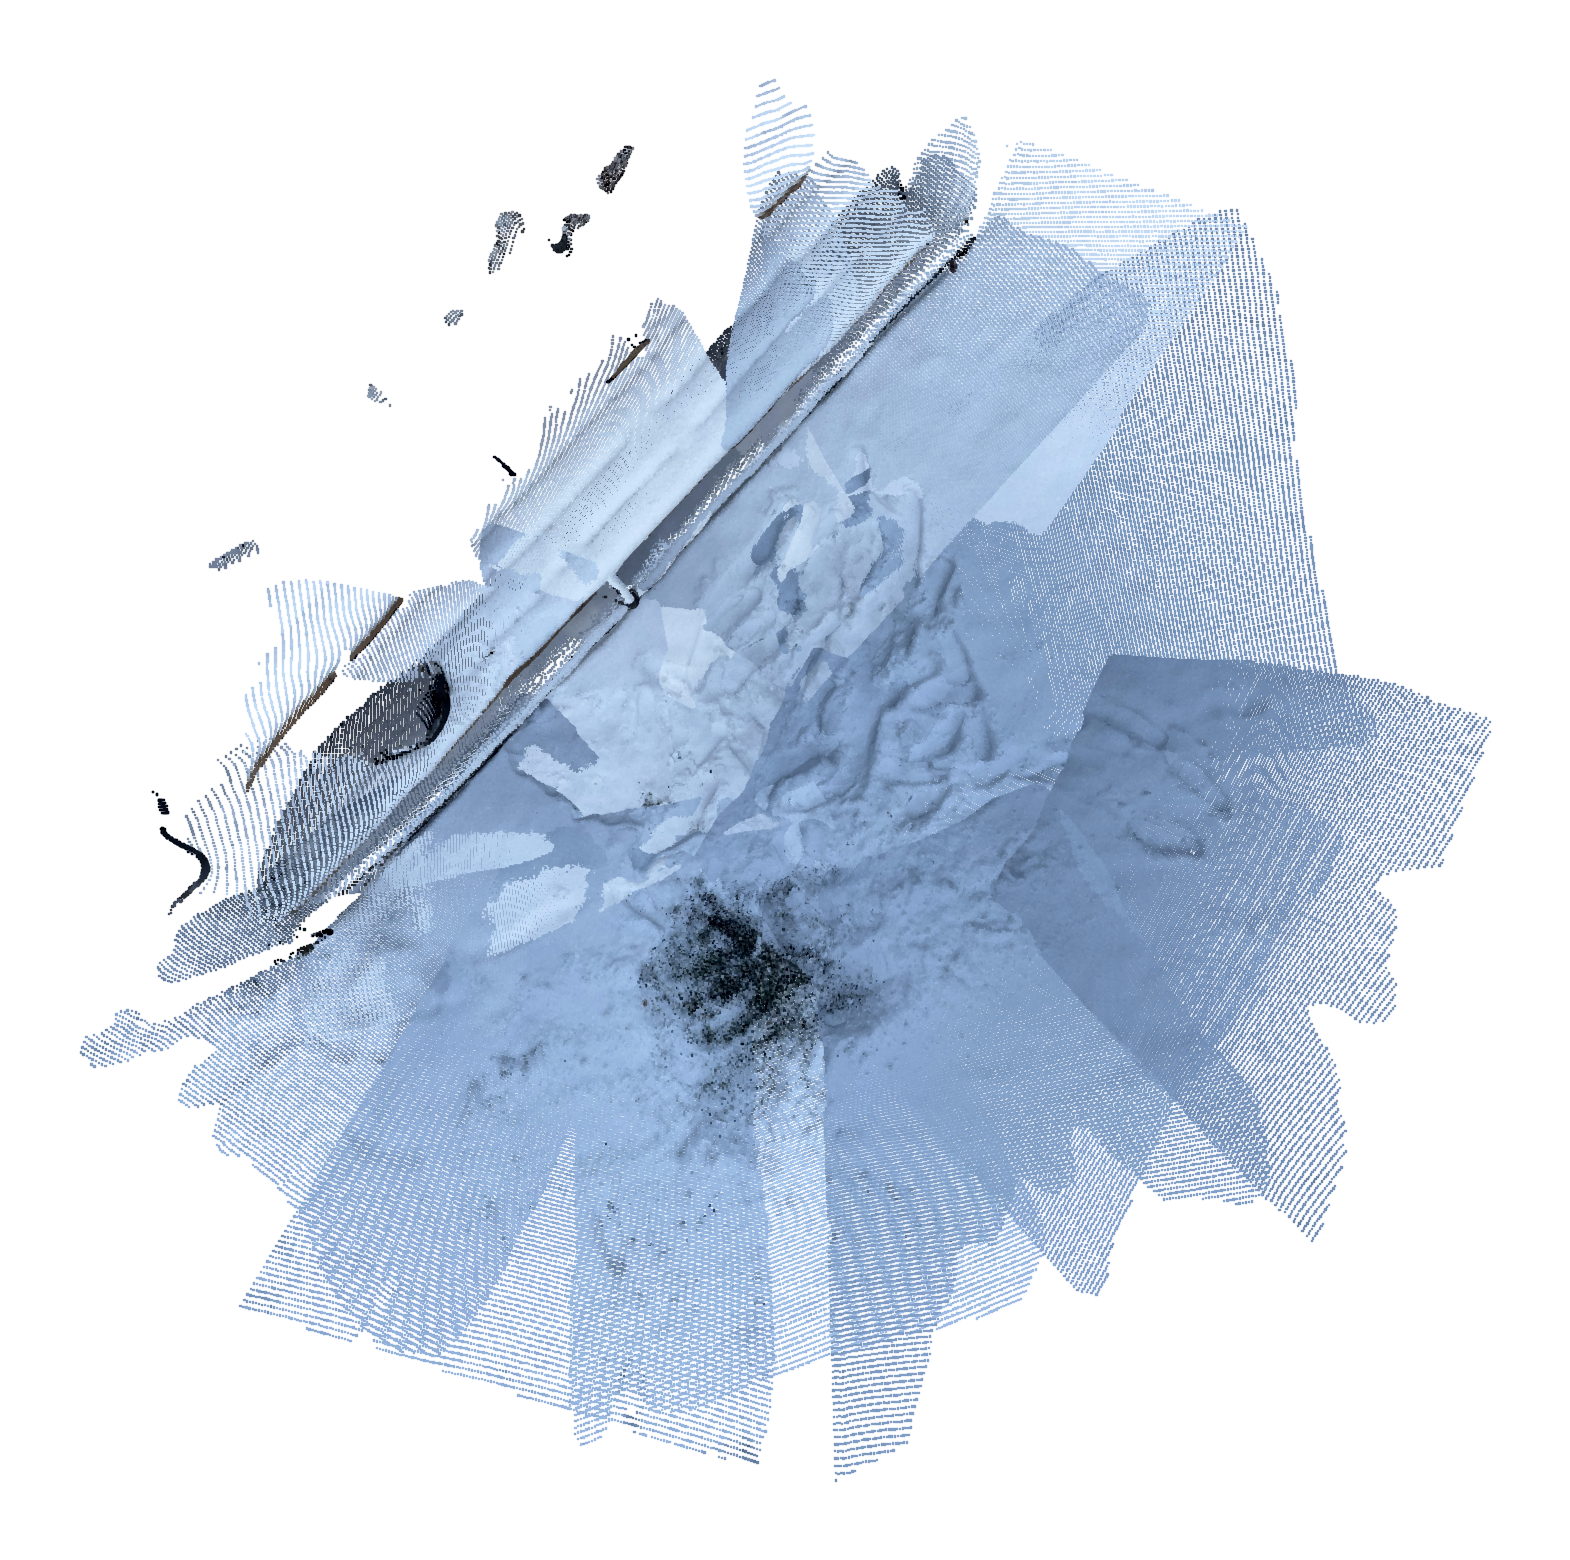

In [47]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
interpolated[interpolated > 255] = 255
interpolated[interpolated < 0] = 0
im = NormalizeData(interpolated)
fig = plt.figure(figsize = (20,20))
ax=fig.add_subplot(1,1,1)
#plt.imshow(im)
plt.axis('off')
plt.scatter(x, y, c=color/255, marker="s",s=1)
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('datasets/drone_1/pointcloud/output.png', bbox_inches=extent)
#plt.savefig('datasets/drone_1/pointcloud/output.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from sys import exit
import os
import random
from operator import sub

################################################################################
# Save and load data                                                           #
################################################################################

def read_imgs(dataset):
    assert(IMNAMES.get(dataset))
    # read images
    imgs = []
    for name in IMNAMES[dataset]:
        path = PREPATH + dataset + '/' + name + EXT
        img = cv.imread(path, cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        imgs.append(img)
    return imgs

# compress data
# no need to provide corresponding pairs for (j, i) where j > i
def save_points(dataset, points):
    N = len(IMNAMES.get(dataset))
    assert(N > 0)
    assert(len(points) == N)
    os.makedirs(NPYDIR, exist_ok=True)
    np.save(NPYDIR + dataset, np.array(points, dtype=object), allow_pickle=True)

# corresponding pointss for (j, i) where j > i are derived from (i, j) pair
def load_points(dataset):
    N = len(IMNAMES.get(dataset))
    assert(N > 0)
    points = np.load(NPYDIR + dataset + '.npy', allow_pickle=True)
    assert(len(points) == N)
    # fill in the blanks (we know A to B, obtain B to A)
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            points[j][i] = [points[i][j][1], points[i][j][0]]
    return points

def save_image(name, img):
    os.makedirs(RESDIR, exist_ok=True)
    if cv.imwrite(RESDIR + name + EXT, cv.cvtColor(img, cv.COLOR_RGB2BGR)):
        print('Saved to', RESDIR + name + EXT)

def save_figure(fig, name):
    plt.figure(fig.number)
    mng = plt.get_current_fig_manager()
    mng.full_screen_toggle()
    fig.show()
    fig.savefig(RESDIR + name + '.png')
    mng.full_screen_toggle()
    print('Saved to ' + RESDIR + name + '.png')

################################################################################
# Corresponding points between images                                          #
################################################################################

def select_points(img, K):
    fig = plt.figure()
    plt.imshow(img)
    x = plt.ginput(K)   # (x, y) format
    plt.close(fig)
    return list(tuple(map(int, tup)) for tup in x)

def cv_mouse_click(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        pos = (x, y)    # cv2 format
        if type(param) is list:
            param.append(pos)

def cv_select_points(img, K, winname, param=[]):
    assert(type(param) is list)
    colors = color_list(K)
    cv.namedWindow(winname)
    cv.setMouseCallback(winname, cv_mouse_click, param)
    while True:
        try:
            cv.imshow(winname, mark_points(img, param, colors, bgr=True))
            ch = cv.waitKey(delay=100) & 0xFF
        # in case of an error, terminate the thread
        except Exception as e:
            print('Exception occured in', winname)
            print(e, flush=True)
            cv.destroyWindow(winname)
            exit(1)
        # press ESC to skip matching
        if ch is 27:
            if len(param) is not 0:
                print('Clear the points first!', flush=True)
            else:
                print('Skipping', winname, flush=True)
                break
        # press BACKSPACE to delete the last selected point
        elif ch is ord('\b'):
            if len(param):
                param.pop()
        # press SPACE when you are done
        elif ch is ord(' '):
            if len(param) is K:
                break
            else:
                print('There should be', K, 'selected points in', winname,
                      'whereas it is', len(param), flush=True)
    cv.destroyWindow(winname)
    return np.array(param)

def select_pair(img1, img2, K, win1, win2, pts1, pts2, print_help=True):
    if print_help:
        print('Select the corresponding %d points' %(K),
              'in each image in the same order')
        print('Press BACKSPACE to delete the last selected point')
        print('Press SPACE when you are done', flush=True)
    futures = [None, None]
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures[0] = executor.submit(cv_select_points, img1, K, win1, pts1)
        futures[1] = executor.submit(cv_select_points, img2, K, win2, pts2)
    return [futures[0].result(), futures[1].result()]

def select_corresponding_points(dataset, K):
    assert(K >= 4)
    imgs = read_imgs(dataset)
    result = [[None for j in range(len(imgs))]
              for i in range(len(imgs))]
    print('Select the corresponding %d points' %(K),
          'in each image in the same order')
    print('Press ESC to skip matching that pair')
    print('Press BACKSPACE to delete the last selected point')
    print('Press SPACE when you are done', flush=True)
    for i in range(len(imgs) - 1):
        for j in range(i + 1, len(imgs)):
            win1 = IMNAMES[dataset][i]
            win2 = IMNAMES[dataset][j]
            img1 = cv.cvtColor(imgs[i], cv.COLOR_RGB2BGR)
            img2 = cv.cvtColor(imgs[j], cv.COLOR_RGB2BGR)
            print('Correspondence between', win1, 'and', win2, flush=True)
            result[i][j] = select_pair(img1, img2, K, win1, win2,
                                       [], [], print_help=False)
            # The following line is performed while loading data
            # result[j][i] = [result[i][j][1], result[i][j][0]]
    return result

def random_points(size, K):
    x = np.random.uniform(low=[0,0], high=[size[1], size[0]], size=(K, 2))
    return list(tuple(map(int, arr)) for arr in x)

################################################################################
# Homography calculation                                                       #
################################################################################

def computeH(src_pts, dst_pts, max_iter=1000, inlier_thr=5):
    assert(len(src_pts) >= 4)
    assert(len(dst_pts) == len(src_pts))
    # apply RANSAC algorithm
    best_inlier = 0     # number of points that are below threshold
    best_dist = float('inf')
    for _ in range(max_iter):
        # pick 4 random point pairs
        idx = random.sample(range(len(src_pts)), 4)
        # calculate homography matrix
        x1, x2, x3, x4 = ((src_pts[i][0], dst_pts[i][0]) for i in idx)
        y1, y2, y3, y4 = ((src_pts[i][1], dst_pts[i][1]) for i in idx)
        P = np.array([
            [-x1[0], -y1[0], -1, 0, 0, 0, x1[0] * x1[1], y1[0] * x1[1], x1[1]],
            [0, 0, 0, -x1[0], -y1[0], -1, x1[0] * y1[1], y1[0] * y1[1], y1[1]],
            [-x2[0], -y2[0], -1, 0, 0, 0, x2[0] * x2[1], y2[0] * x2[1], x2[1]],
            [0, 0, 0, -x2[0], -y2[0], -1, x2[0] * y2[1], y2[0] * y2[1], y2[1]],
            [-x3[0], -y3[0], -1, 0, 0, 0, x3[0] * x3[1], y3[0] * x3[1], x3[1]],
            [0, 0, 0, -x3[0], -y3[0], -1, x3[0] * y3[1], y3[0] * y3[1], y3[1]],
            [-x4[0], -y4[0], -1, 0, 0, 0, x4[0] * x4[1], y4[0] * x4[1], x4[1]],
            [0, 0, 0, -x4[0], -y4[0], -1, x4[0] * y4[1], y4[0] * y4[1], y4[1]],
            ])
        [U, S, Vt] = np.linalg.svd(P)
        H = Vt[-1].reshape(3, 3)
        H /= H[2][2]
        # see how good the matches are
        pts = transform(src_pts, H)
        distvec = np.sqrt(np.sum(np.square(pts - dst_pts), axis=1))
        dist = np.mean(distvec[distvec < inlier_thr])
        inlier = np.count_nonzero(distvec < inlier_thr)
        if inlier > best_inlier or (inlier is best_inlier and dist < best_dist):
            best_inlier = inlier
            best_dist = dist
            best_H = H
    return best_H

################################################################################
# Transformation functions                                                     #
################################################################################

def transform(src_pts, H):
    # src = [src_pts 1]
    src = np.pad(src_pts, [(0, 0), (0, 1)], constant_values=1)
    # pts = H * src
    pts = np.dot(H, src.T).T
    # normalize and throw z=1
    pts = (pts / pts[:,-1].reshape(-1, 1))[:, 0:2]
    return pts

# find the ROI of a transformation result
def warpRect(rect, H):
    x, y, w, h = rect
    corners = [[x, y], [x, y + h - 1], [x + w - 1, y], [x + w - 1, y + h - 1]]
    extremum = transform(corners, H)
    minx, miny = np.min(extremum[:,0]), np.min(extremum[:,1])
    maxx, maxy = np.max(extremum[:,0]), np.max(extremum[:,1])
    xo = int(np.floor(minx))
    yo = int(np.floor(miny))
    wo = int(np.ceil(maxx - minx))
    ho = int(np.ceil(maxy - miny))
    outrect = (xo, yo, wo, ho)
    return outrect

def size2rect(size):
    return (0, 0, size[1], size[0])

# homography matrix is translated to fit in the screen
def coverH(rect, H):
    # obtain bounding box of the result
    x, y, _, _ = warpRect(rect, H)
    # shift amount to the first quadrant
    xpos, ypos = int(0), int(0)
    if x < 0:
        xpos = int(-x)
    if y < 0:
        ypos = int(-y)
    # correct the homography matrix so that no point is thrown out
    T = np.array([[1, 0, xpos], [0, 1, ypos], [0, 0, 1]])
    H_corr = T.dot(H)
    return (H_corr, (xpos, ypos))

# pad image to cover ROI, return the shift amount of origin
def addBorder(img, rect):
    top, bottom, left, right = int(0), int(0), int(0), int(0)
    x, y, w, h = rect
    tl = (x, y)    
    br = (x + w, y + h)
    if tl[1] < 0:
        top = -tl[1]
    if br[1] > img.shape[0]:
        bottom = br[1] - img.shape[0]
    if tl[0] < 0:
        left = -tl[0]
    if br[0] > img.shape[1]:
        right = br[0] - img.shape[1]
    img = cv.copyMakeBorder(img, top, bottom, left, right,
                            cv.BORDER_CONSTANT, value=[0, 0, 0])
    orig = (left, top)
    return img, orig

def check_limits(pts, size):
    np.clip(pts[:,0], 0, size[1] - 1, pts[:,0])
    np.clip(pts[:,1], 0, size[0] - 1, pts[:,1])
    return pts

################################################################################
# Stitching functions                                                          #
################################################################################

def warpImage(img, H):
    # tweak the homography matrix to move the result to the first quadrant
    H_cover, pos = coverH(size2rect(img.shape), H)
    # find the bounding box of the output
    x, y, w, h = warpRect(size2rect(img.shape), H_cover)
    width, height = x + w, y + h
    assert(width * height < 1e8)    # do not exceed 300 MB for 8 GB RAM
    # warp the image using the corrected homography matrix
    # all the fuss is because of the indexing conventions of numpy and cv2
    # warped = cv.warpPerspective(img, H_corr, (width, height))
    idx_pts = np.mgrid[0:width, 0:height].reshape(2, -1).T
    map_pts = transform(idx_pts, np.linalg.inv(H_cover))
    map_pts = map_pts.reshape(width, height, 2).astype(np.float32)
    warped = cv.remap(img, map_pts, None, cv.INTER_CUBIC).transpose(1, 0, 2)
    # make the external boundary solid black, useful for masking
    warped = np.ascontiguousarray(warped, dtype=np.uint8)
    gray = cv.cvtColor(warped, cv.COLOR_RGB2GRAY)
    _, bw = cv.threshold(gray, 1, 255, cv.THRESH_BINARY)
    # https://stackoverflow.com/a/55806272/12447766
    major = cv.__version__.split('.')[0]
    if major == '3':
        _, cnts, _ = cv.findContours(bw, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    else:
        cnts, _ = cv.findContours(bw, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    warped = cv.drawContours(warped, cnts, 0, [0, 0, 0], lineType=cv.LINE_4)
    return (warped, pos)

# only the non-zero pixels are weighted to the average
def mean_blend(img1, img2):
    assert(img1.shape == img2.shape)
    locs1 = np.where(cv.cvtColor(img1, cv.COLOR_RGB2GRAY) != 0)
    blended1 = np.copy(img2)
    blended1[locs1[0], locs1[1]] = img1[locs1[0], locs1[1]]
    locs2 = np.where(cv.cvtColor(img2, cv.COLOR_RGB2GRAY) != 0)
    blended2 = np.copy(img1)
    blended2[locs2[0], locs2[1]] = img2[locs2[0], locs2[1]]
    blended = cv.addWeighted(blended1, 0.5, blended2, 0.5, 0)
    return blended

def blend_images(imageA, imageB, H):
    return warpPano(imageA, imageB, H, (0, 0))

def cv_blend_images(imageA, imageB, H):
    # move origin to cover the third quadrant
    H_corr, pos = coverH(size2rect(imageA.shape), H)
    xpos, ypos = pos
    # warp the image and paste the original one
    result = cv.warpPerspective(imageA, H_corr, (5000, 5000))
    bottom, right = int(0), int(0)
    if ypos + imageB.shape[0] > result.shape[0]:
        bottom = ypos + imageB.shape[0] - result.shape[0]
    if xpos + imageB.shape[1] > result.shape[1]:
        right = xpos + imageB.shape[1] - result.shape[1]
    result = cv.copyMakeBorder(result, 0, bottom, 0, right,
                               cv.BORDER_CONSTANT, value=[0, 0, 0])
    # mean value blending
    idx = np.s_[ypos:ypos+imageB.shape[0], xpos:xpos+imageB.shape[1]]
    result[idx] = mean_blend(result[idx], imageB)
    # crop extra paddings
    x,y,w,h = cv.boundingRect(cv.cvtColor(result, cv.COLOR_RGB2GRAY))
    result = result[0:y+h,0:x+w]
    # return the resulting image with shift amount
    return (result, (xpos, ypos))

def warpPano(prevPano, img, H, orig):
    # corret homography matrix
    T = np.array([[1, 0, -orig[0]], [0, 1, -orig[1]], [0, 0, 1]])
    H_corr = H.dot(T)
    # warp the image and obtain shift amount of origin
    result, pos = warpImage(prevPano, H_corr)
    xpos, ypos = pos
    # zero pad the result
    rect = (xpos, ypos, img.shape[1], img.shape[0])
    result, _ = addBorder(result, rect)
    # mean value blending
    idx = np.s_[ypos : ypos + img.shape[0], xpos : xpos + img.shape[1]]
    result[idx] = mean_blend(result[idx], img)
    # crop extra paddings
    x, y, w, h = cv.boundingRect(cv.cvtColor(result, cv.COLOR_RGB2GRAY))
    result = result[y : y + h, x : x + w]
    # return the resulting image with shift amount
    return (result, (xpos - x, ypos - y))

# no warping here, useful for combining two different stitched images
# the image at given origin coordinates must be the same
def patchPano(img1, img2, orig1=(0,0), orig2=(0,0)):
    # bottom right points
    br1 = (img1.shape[1] - 1, img1.shape[0] - 1)
    br2 = (img2.shape[1] - 1, img2.shape[0] - 1)
    # distance from orig to br
    diag2 = tuple(map(sub, br2, orig2))
    # possible pano corner coordinates based on img1
    extremum = np.array([(0, 0), br1,
                tuple(map(sum, zip(orig1, diag2))),
                tuple(map(sub, orig1, orig2))])
    bb = cv.boundingRect(extremum)
    # patch img1 to img2
    pano, shift = addBorder(img1, bb)
    orig = tuple(map(sum, zip(orig1, shift)))
    idx = np.s_[orig[1] : orig[1] + img2.shape[0] - orig2[1],
                orig[0] : orig[0] + img2.shape[1] - orig2[0]]
    subImg = img2[orig2[1] : img2.shape[0], orig2[0] : img2.shape[1]]
    pano[idx] = mean_blend(pano[idx], subImg)
    return (pano, orig)

# base image is the last image in each iteration
def blend_multiple_images(images, homographies):
    N = len(images)
    assert(N >= 2)
    assert(len(homographies) == N - 1)
    pano = np.copy(images[0])
    pos = (0, 0)
    for i in range(N - 1):
        # get homography matrix
        img = images[i + 1]
        H = homographies[i]
        # warp pano onto image
        pano, pos = warpPano(pano, img, H, pos)
    return (pano, pos)

################################################################################
# Miscellaneous                                                                #
################################################################################

def color_list(N, colormap=cv.COLORMAP_HSV):
    cmap = cv.applyColorMap(np.array(range(256), np.uint8), colormap)
    return list(tuple(int(c) for c in cmap[int(256*n/N)][0]) for n in range(N))

def mark_points(img, x, colormap=cv.COLORMAP_HSV, bgr=False):
    marked = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    if colormap == 'invert':
        colors = list(tuple(int(256-v) for v in img[p]) for p in x)
    elif type(colormap) is list:
        if len(colormap) >= len(x):
            colors = colormap
        else:
            colors = color_list(len(x))
    else:
        colors = color_list(len(x), colormap)
    for i in range(len(x)):
        marked = cv.drawMarker(marked, (int(x[i][0]), int(x[i][1])), colors[i],
                               cv.MARKER_CROSS, markerSize=30, thickness=2)
    if bgr:
        return marked
    else:
        return cv.cvtColor(marked, cv.COLOR_BGR2RGB)

def match_points(img1, img2, pts1, pts2, colors=None, hstack=True):
    if colors is None:
        colors = color_list(len(pts1))
    if img1.shape != img2.shape:
        img1b = cv.copyMakeBorder(img1, 0, # up
                                  max(img2.shape[0] - img1.shape[0], 0), # down
                                  0, # left
                                  max(img2.shape[1] - img1.shape[1], 0), # right
                                  cv.BORDER_CONSTANT, value=[0, 0, 0])
        img2b = cv.copyMakeBorder(img2, 0, # up
                                  max(img1.shape[0] - img2.shape[0], 0), # down
                                  0, # left
                                  max(img1.shape[1] - img2.shape[1], 0), # right
                                  cv.BORDER_CONSTANT, value=[0, 0, 0])
        img1 = img1b
        img2 = img2b
    img = np.concatenate((img1, img2), axis=int(hstack))
    for i in range(len(pts1)):
        pt1 = tuple(pts1[i])
        if hstack:
            pt2 = (pts2[i][0] + img1.shape[1], pts2[i][1])
        else:
            pt2 = (pts2[i][0], pts2[i][1] + img1.shape[0])
        img = cv.line(img, pt1, pt2, colors[i], 3, cv.LINE_AA)
    return img

################################################################################
# Display results                                                              #
################################################################################

# NxN matrix
# points[i][j] represents correspondence from image[i] to image[j]
# Not necessarily filled, if there is no common point
# points[i][i]: always None, why would you use that?
# points[i][j][0]: first image points (in [x, y] form)
# points[i][j][1]: second image points (same, cv2 format, NOT [row, column])
def print_points(points):
    for i in range(len(points)):
        print('\trow', i)
        for j in range(len(points[i])):
            print('\t\tcolumn', j)
            print(points[i][j])
        print('')

def show_matches(dataset, points):
    imgs = read_imgs(dataset)
    colors = color_list(len(points[0][1][0]))
    for i in range(len(imgs) - 1):
        for j in range(i + 1, len(imgs)):
            img1 = imgs[i]
            img2 = imgs[j]
            pts1 = points[i][j][0]
            pts2 = points[i][j][1]
            img = match_points(img1, img2, pts1, pts2, colors)
            # draw results
            plt.figure()
            plt.imshow(img)
            plt.title(IMNAMES[dataset][i] + ' - ' + IMNAMES[dataset][j])
    # results are displayed here
    plt.show()

def show_warp_and_match(warped, matched):
    fig = plt.figure()
    gs = fig.add_gridspec(2, 3)
    ax_warped = fig.add_subplot(gs[:, 0:2])
    ax_warped.imshow(warped)
    ax_warped.set_title('Warping Result')
    ax_matched = fig.add_subplot(gs[:, 2])
    ax_matched.imshow(matched)
    ax_matched.set_title('Matching Points')
    return fig

################################################################################
# test Homography and Image Stitching                                          #
################################################################################

def test_save_points(dataset):
    print('Running test_save_points for %s dataset' % dataset)
    # select corresponding points in each image manually
    points = select_corresponding_points(dataset, K=5)
    save_points(dataset, points)
    # load previously saved corresponding points
    points = load_points(dataset)
    print_points(points)
    show_matches(dataset, points)

def test_check_points(dataset, h_use_cv=False, w_use_cv=False):
    print('Running test_check_points for %s dataset' % dataset)
    print('OpenCV usage: homography (%s), warping (%s)' % (h_use_cv, w_use_cv))
    points = load_points(dataset)
    imgs = read_imgs(dataset)
    colors = color_list(len(points[0][1][0]))
    disp = lambda img, h=480 : cv.cvtColor(cv.resize(img, (0, 0),
            fx=h/img.shape[0], fy=h/img.shape[0]), cv.COLOR_RGB2BGR)
    for i in range(len(points)):
        for j in range(i):
            points[i][j] = None
    print('Check whether the points are selected well')
    print('Press ENTER to re-select and save points for that image pair')
    print('Press any other key to continue to the next image pair')
    print('Press ESC to exit')
    for i in range(len(points)):
        j = i
        while j + 1 < len(points):
            j += 1
            img1 = imgs[i]
            img2 = imgs[j]
            pts1 = points[i][j][0]
            pts2 = points[i][j][1]
            if len(pts1):
                if h_use_cv:
                    H, _ = cv.findHomography(pts1, pts2)
                else:
                    H = computeH(pts1, pts2)
                if w_use_cv:
                    warped, _ = cv_blend_images(img1, img2, H)
                else:
                    warped, _ = blend_images(img1, img2, H)
                matched = match_points(img1, img2, pts1, pts2)
                winM = '%s_matched_%d-%d' % (dataset, i, j)
                winW = '%s_warped_%d-%d' % (dataset, i, j)
                cv.imshow(winM, disp(matched))
                cv.imshow(winW, disp(warped))
                ch = cv.waitKey() & 0xFF
                cv.destroyWindow(winM)
                cv.destroyWindow(winW)
                # press ENTER to re-select points
                if ch == 13:
                    win1, win2 = '%s_%d' % (dataset, i), '%s_%d' % (dataset, j)
                    points[i][j] = select_pair(img1, img2, len(pts1), win1,
                                               win2, list(pts1), list(pts2))
                    save_points(dataset, points)
                    points = load_points(dataset)
                    j -= 1
                # press ESC to exit
                elif ch == 27:
                    return

def test_image_pair(dataset, id_from, id_to, den=1,
                    h_use_cv=False, w_use_cv=False):
    print('Running test_image_pair for %s dataset' % dataset)
    print('Stitching from #%d to #%d with a downscale factor of %.1f' % (
        id_from, id_to, den))
    print('OpenCV usage: homography (%s), warping (%s)' % (h_use_cv, w_use_cv))
    imgs = read_imgs(dataset)
    img1 = cv.resize(imgs[id_from], (0, 0), fx=1/den, fy=1/den)
    img2 = cv.resize(imgs[id_to], (0, 0), fx=1/den, fy=1/den)
    points = load_points(dataset)
    pts1 = points[id_from][id_to][0] / den
    pts2 = points[id_from][id_to][1] / den
    # calculate homography matrix
    if h_use_cv:
        H, _ =  cv.findHomography(pts1, pts2)
    else:
        H = computeH(pts1, pts2)
    # warp the first image onto the second one
    if w_use_cv:
        blended, _ = cv_blend_images(img1, img2, H)
    else:
        blended, _ = blend_images(img1, img2, H)
    # display the result
    plt.imshow(blended)
    plt.title('Image Pair %d-%d' % (id_from, id_to))
    plt.show()

def test_stitch_all(dataset, den=4):
    print('Running test_stitch_all for %s dataset' % dataset)
    print('Downscale factor: %.1f' % den)
    # stitch all images
    imgs = read_imgs(dataset)
    points = load_points(dataset)
    for i in range(len(imgs)):
        imgs[i] = cv.resize(imgs[i], (0, 0), fx=1/den, fy=1/den)
    pano = np.copy(imgs[0])
    xpos, ypos = int(0), int(0)
    homographies = []
    for i in range(1, len(imgs)):
        img = imgs[i]
        pts1 = points[i-1][i][0] / den
        pts2 = points[i-1][i][1] / den
        H = computeH(pts1, pts2)
        homographies.append(H)
    pano, _ = blend_multiple_images(imgs, homographies)
    plt.imshow(pano)
    plt.title('All %s Images Stitched' % (dataset))
    plt.show()

################################################################################
# task Homography and Image Stitching                                          #
################################################################################

def task_mosaic_paris():
    print('Running task_mosaic_paris')
    dataset = 'paris'
    points = load_points(dataset)
    imgs = read_imgs(dataset)
    # a to b
    pts1 = points[0][1][0]
    pts2 = points[0][1][1]
    Hab = computeH(pts1, pts2)
    panoA, posA = blend_images(imgs[0], imgs[1], Hab)
    # c to b
    pts1 = points[2][1][0]
    pts2 = points[2][1][1]
    Hcb = computeH(pts1, pts2)
    panoC, posC = blend_images(imgs[2], imgs[1], Hcb)
    # all together
    pano, _ = patchPano(panoA, panoC, posA, posC)
    # display and save results
    plt.imshow(pano)
    plt.title('Paris Mosaic')
    plt.show()
    save_image('mosaic_paris', pano)

def task_mosaic_5(dataset, method, den=1):
    print('Running task_mosaic_5 for %s dataset' % dataset)
    print('Method: %s' % method)
    print('Downscale factor: %.1f' % den)
    assert(method in METHODS)
    imgs = read_imgs(dataset)
    assert(len(imgs) == 5)
    for i in range(len(imgs)):
        imgs[i] = cv.resize(imgs[i], (0, 0), fx=1/den, fy=1/den)
    points = load_points(dataset)
    for i in range(len(points)):
        for j in range(len(points)):
            if i != j:
                points[i][j][0] = points[i][j][0] / den
                points[i][j][1] = points[i][j][1] / den
    if method is METHODS[0]:    # left-to-right
        # left1 to left2
        pts1 = points[1][0][0]
        pts2 = points[1][0][1]
        H = computeH(pts1, pts2)
        pano1, pos1 = blend_images(imgs[1], imgs[0], H)
        # middle to left2
        pts1 = points[2][0][0]
        pts2 = points[2][0][1]
        H = computeH(pts1, pts2)
        pano2, pos2 = blend_images(imgs[2], imgs[0], H)
        pano, pos = patchPano(pano1, pano2, pos1, pos2)
        # right1 to left2
        pts1 = points[3][0][0]
        pts2 = points[3][0][1]
        H = computeH(pts1, pts2)
        pano3, pos3 = blend_images(imgs[3], imgs[0], H)
        pano, pos = patchPano(pano, pano3, pos, pos3)
        # right2 to left2
        pts1 = points[4][0][0]
        pts2 = points[4][0][1]
        H = computeH(pts1, pts2)
        pano4, pos4 = blend_images(imgs[4], imgs[0], H)
        pano, pos = patchPano(pano, pano4, pos, pos4)
    elif method is METHODS[1]:  # middle-out
        # left1 to middle
        pts1 = points[1][2][0]
        pts2 = points[1][2][1]
        H = computeH(pts1, pts2)
        pano1, pos1 = blend_images(imgs[1], imgs[2], H)
        # right1 to middle
        pts1 = points[3][2][0]
        pts2 = points[3][2][1]
        H = computeH(pts1, pts2)
        pano3, pos3 = blend_images(imgs[3], imgs[2], H)
        # mosaic1
        pano2, pos2 = patchPano(pano1, pano3, pos1, pos3)
        # left2 to middle
        pts1 = points[0][2][0]
        pts2 = points[0][2][1]
        H = computeH(pts1, pts2)
        pano0, pos0 = blend_images(imgs[0], imgs[2], H)
        # right2 to middle
        pts1 = points[4][2][0]
        pts2 = points[4][2][1]
        H = computeH(pts1, pts2)
        pano4, pos4 = blend_images(imgs[4], imgs[2], H)
        # mosaic2
        pano, pos = patchPano(pano0, pano4, pos0, pos4)
        # all together
        pano, pos = patchPano(pano, pano2, pos, pos2)
    else:   # first-out-then-middle
        # left2 to left1
        pts1 = points[0][1][0]
        pts2 = points[0][1][1]
        H = computeH(pts1, pts2)
        pano1, pos1 = blend_images(imgs[0], imgs[1], H)
        # right2 to right1
        pts1 = points[4][3][0]
        pts2 = points[4][3][1]
        H = computeH(pts1, pts2)
        pano3, pos3 = blend_images(imgs[4], imgs[3], H)
        # left1 to middle
        pts1 = points[1][2][0]
        pts2 = points[1][2][1]
        H = computeH(pts1, pts2)
        pano_left, pos_left = warpPano(pano1, imgs[2], H, pos1)
        # right1 to middle
        pts1 = points[3][2][0]
        pts2 = points[3][2][1]
        H = computeH(pts1, pts2)
        pano_right, pos_right = warpPano(pano3, imgs[2], H, pos3)
        # all together
        pano, pos = patchPano(pano_left, pano_right, pos_left, pos_right)
    # display and save result
    plt.imshow(pano)
    plt.title('%s Mosaic with %s Method' % (dataset, method))
    plt.show()
    save_image('mosaic_' + dataset + '_' + method, pano)

def task_corresponding_pairs(id_from, id_to, K=8):
    assert(K >= 8)
    # load data
    dataset = 'paris'
    print('Running task_corresponding_pairs for %s dataset' % dataset)
    print('Stitching from #%d to #%d with %d corresponding points' % (
        id_from, id_to, K))
    imgs = read_imgs(dataset)
    points = load_points(dataset)
    img1, img2 = imgs[id_from], imgs[id_to]
    pts1, pts2 = points[id_from][id_to][0], points[id_from][id_to][1]
    # select corresponding point pairs if not sufficient
    if len(pts1) < K:
        win1, win2 = IMNAMES[dataset][id_from], IMNAMES[dataset][id_to]
        pts1 = [(pt[0], pt[1]) for pt in pts1]
        pts2 = [(pt[0], pt[1]) for pt in pts2]
        pts1, pts2 = select_pair(img1, img2, K, win1, win2, pts1, pts2)
    # warp image using 5 point pairs
    pts1_5, pts2_5 = pts1[0:5], pts2[0:5]
    H_5 = computeH(pts1_5, pts2_5)
    warped_5, _ = blend_images(img1, img2, H_5)
    matched_5 = match_points(img1, img2, pts1_5, pts2_5, hstack=False)
    # warp image using K point pairs
    pts1_K, pts2_K = pts1[0:K], pts2[0:K]
    H_K = computeH(pts1_K, pts2_K)
    warped_K, _ = blend_images(img1, img2, H_K)
    matched_K = match_points(img1, img2, pts1_K, pts2_K, hstack=False)
    # compare and save the results
    fig5 = show_warp_and_match(warped_5, matched_5)
    fig5.suptitle('5 Corresponding Point Pairs')
    figK = show_warp_and_match(warped_K, matched_K)
    figK.suptitle('%d corresponding point pairs' % (K))
    os.makedirs(RESDIR, exist_ok=True)
    save_figure(fig5, 'corresponding-5_%d-%d' % (id_from, id_to))
    save_figure(figK, 'corresponding-%d_%d-%d' % (K, id_from, id_to))
    plt.show()

def task_point_selection(id_from, id_to, wrong=5):
    assert(wrong >= 5)
    # load data
    dataset = 'paris'
    print('Running task_point_selection for %s dataset' % dataset)
    print('Stitching from #%d to #%d with %d wrong corresponding points' % (
        id_from, id_to, wrong))
    imgs = read_imgs(dataset)
    points = load_points(dataset)
    img1 = imgs[id_from]
    img2 = imgs[id_to]
    pts1 = points[id_from][id_to][0]
    pts2 = points[id_from][id_to][1]
    # add wrong point pairs
    rand1 = random_points(img1.shape, wrong)
    rand2 = random_points(img2.shape, wrong)
    pts1_w = np.append(pts1, rand1, axis=0)
    pts2_w = np.append(pts2, rand2, axis=0)
    # warp image using original data
    H = computeH(pts1, pts2)
    warped, _ = blend_images(img1, img2, H)
    matched = match_points(img1, img2, pts1, pts2, hstack=False)
    # warp image using wrong data
    H_w = computeH(pts1_w, pts2_w)
    warped_w, _ = blend_images(img1, img2, H_w)
    matched_w = match_points(img1, img2, pts1_w, pts2_w, hstack=False)
    # compare and save the results
    fig = show_warp_and_match(warped, matched)
    fig.suptitle('Original')
    fig_w = show_warp_and_match(warped_w, matched_w)
    fig_w.suptitle('Wrong Points')
    os.makedirs(RESDIR, exist_ok=True)
    save_figure(fig, 'selection-original_%d-%d' % (id_from, id_to))
    save_figure(fig_w, 'selection-wrong-%d_%d-%d' % (wrong, id_from, id_to))
    plt.show()

def task_noisy_points(id_from, id_to, noise=5):
    # load data
    dataset = 'paris'
    print('Running task_noisy_points for %s dataset' % dataset)
    print('Stitching from #%d to #%d with a noise of %d pixels' % (
        id_from, id_to, noise))
    imgs = read_imgs(dataset)
    points = load_points(dataset)
    img1 = imgs[id_from]
    img2 = imgs[id_to]
    pts1 = points[id_from][id_to][0]
    pts2 = points[id_from][id_to][1]
    # add noise to corresponding point pairs
    rand1 = np.random.randint(-noise, noise, size=pts1.shape)
    rand2 = np.random.randint(-noise, noise, size=pts2.shape)
    pts1_n = check_limits(pts1 + rand1, img1.shape)
    pts2_n = check_limits(pts2 + rand2, img2.shape)
    # warp image using original data
    H = computeH(pts1, pts2)
    warped, _ = blend_images(img1, img2, H)
    matched = match_points(img1, img2, pts1, pts2, hstack=False)
    # warp image using noisy data
    H_n = computeH(pts1_n, pts2_n)
    warped_n, _ = blend_images(img1, img2, H_n)
    matched_n = match_points(img1, img2, pts1_n, pts2_n, hstack=False)
    # compare and save the results
    fig = show_warp_and_match(warped, matched)
    fig.suptitle('Original')
    fig_n = show_warp_and_match(warped_n, matched_n)
    fig_n.suptitle('Noisy Points')
    os.makedirs(RESDIR, exist_ok=True)
    save_figure(fig, 'noisy-original_%d-%d' % (id_from, id_to))
    save_figure(fig_n, 'noisy-added-%d_%d-%d' % (noise, id_from, id_to))
    plt.show()

def task_normalized_points(id_from, id_to):
    # load data
    dataset = 'paris'
    print('Running task_normalized_points for %s dataset' % dataset)
    print('Stitching from #%d to #%d' % (id_from, id_to))
    imgs = read_imgs(dataset)
    points = load_points(dataset)
    img1 = imgs[id_from]
    img2 = imgs[id_to]
    pts1 = points[id_from][id_to][0]
    pts2 = points[id_from][id_to][1]
    # normalize the points
    mean1 = np.mean(pts1, axis=0)
    var1 = pts1 - mean1
    coef1 = np.sqrt(2) / np.mean(np.sqrt(np.sum(np.square(var1), axis=1)))
    pts1_n = coef1 * var1   # average distance: sqrt(2)
    mean2 = np.mean(pts2, axis=0)
    var2 = pts2 - mean2
    coef2 = np.sqrt(2) / np.mean(np.sqrt(np.sum(np.square(var2), axis=1)))
    pts2_n = coef2 * var2   # average distance: sqrt(2)
    # calculate the effects of normalization on homography matrix
    # C2 * T2 * pts2 = H_n * C1 * T1 * pts1
    T1 = np.array([[1, 0, -mean1[0]], [0, 1, -mean1[1]], [0, 0, 1]])
    C1 = np.array([[coef1, 0, 0], [0, coef1, 0], [0, 0, 1]])
    H_n = computeH(pts1_n, pts2_n, inlier_thr=0.1)
    T2 = np.array([[1, 0, -mean2[0]], [0, 1, -mean2[1]], [0, 0, 1]])
    C2 = np.array([[coef2, 0, 0], [0, coef2, 0], [0, 0, 1]])
    H_n_eff = np.linalg.inv(C2.dot(T2)).dot(H_n.dot(C1.dot(T1)))
    # warp image
    H = computeH(pts1, pts2)
    warped, _ = blend_images(img1, img2, H)
    warped_n, _ = blend_images(img1, img2, H_n_eff)
    # compare and save the results
    plt.imshow(warped)
    plt.title('Original Warping Result')
    plt.figure()
    plt.imshow(warped_n)
    plt.title('Normalized Points Warping Result')
    plt.show()
    save_image('normalized-original_%d-%d' % (id_from, id_to), warped)
    save_image('normalized-result_%d-%d' % (id_from, id_to), warped_n)

################################################################################
# Path to sets of images                                                       #
################################################################################

PREPATH = 'images/'
IMNAMES = {
    'cmpe_building': ['left_2', 'left_1', 'middle', 'right_1', 'right_2'],
    'north_campus': ['left_2', 'left_1', 'middle', 'right_1', 'right_2'],
    'paris': ['paris_a', 'paris_b', 'paris_c',],
    'book': ['book_table', 'book_orig'] # test dataset
}
EXT = '.jpg'

NPYDIR = 'data/'

RESDIR = 'results/'

METHODS = ['left-to-right', 'middle-out', 'first-out-then-middle']

################################################################################
# main Homography and Image Stitching                                          #
################################################################################

#test_save_points('book')
test_check_points('book', h_use_cv=False, w_use_cv=False)
test_image_pair('cmpe_building', 4, 0, den=1, w_use_cv=False)
test_stitch_all('cmpe_building', den=1)

task_mosaic_paris()
task_mosaic_5('cmpe_building', 'left-to-right')
task_mosaic_5('cmpe_building', 'middle-out')
task_mosaic_5('cmpe_building', 'first-out-then-middle')
task_mosaic_5('north_campus', 'first-out-then-middle', den=2)

id_from, id_to = 2, 1   # available: (0, 1, 2)
task_corresponding_pairs(id_from, id_to, K=8)
task_point_selection(id_from, id_to, wrong=5)
task_noisy_points(id_from, id_to, noise=5)
task_normalized_points(id_from, id_to)